In [ ]:
import time, statistics as stats
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

def timeit_ms(fn, *args, repeat=50, warmup=10, **kwargs):
    for _ in range(warmup):
        fn(*args, **kwargs)
    t = []
    for _ in range(repeat):
        t0 = time.perf_counter()
        fn(*args, **kwargs)
        t.append((time.perf_counter() - t0) * 1000.0)
    return {"mean_ms": round(stats.mean(t), 3),
            "std_ms": round(stats.pstdev(t), 3),
            "repeat": repeat}

In [ ]:
res = {
    "n": [],
    "int mean_ms": [],
    "int std_ms": [],
    "float32 mean_ms": [],
    "float32 std_ms": [],
}
for i in tqdm(range(1, 9)):
    n = int(torch.e ** i)
    res["n"].append(n)

    # int8
    A_i8 = torch.randint(0, 2, (n, n), dtype=torch.int8)
    B_i8 = torch.randint(0, 2, (n, n), dtype=torch.int8)
    r_i8 = timeit_ms(torch.matmul, repeat = 3, warmup=1,input=A_i8, other=B_i8)
    res["int mean_ms"].append(r_i8["mean_ms"])
    res["int std_ms"].append(r_i8["std_ms"])

    # float32
    A_f = torch.randn((n, n), dtype=torch.float32)
    B_f = torch.randn((n, n), dtype=torch.float32)
    r_f = timeit_ms(torch.matmul, repeat = 3, warmup=1,input=A_f, other=B_f)
    res["float32 mean_ms"].append(r_f["mean_ms"])
    res["float32 std_ms"].append(r_f["std_ms"])

100%|██████████| 8/8 [00:39<00:00,  4.91s/it]


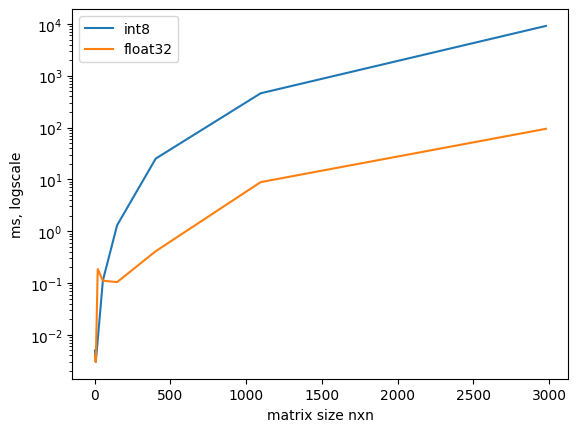

In [ ]:
plt.plot(res["n"], res["int mean_ms"], label="int8")
plt.plot(res["n"], res["float32 mean_ms"], label="float32")
plt.yscale("log")
plt.ylabel("ms, logscale")
plt.xlabel("matrix size nxn")
plt.legend()

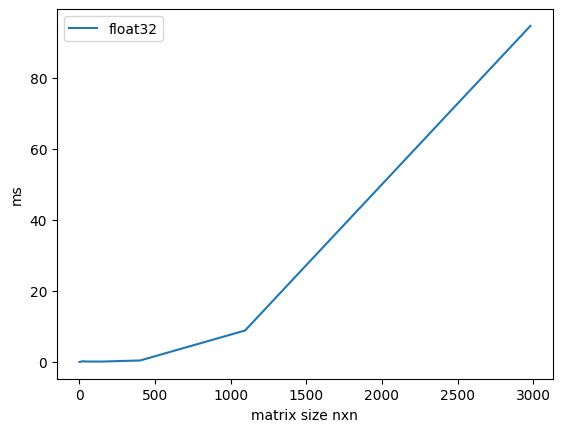

In [11]:
plt.plot(res["n"], res["float32 mean_ms"], label="float32")
plt.ylabel("ms")
plt.xlabel("matrix size nxn")
plt.legend()

In [21]:
import numpy as np
res = {
    "n": [],
    "int mean_ms": [],
    "int std_ms": [],
    "float32 mean_ms": [],
    "float32 std_ms": [],
}

for i in tqdm(range(1, 9)):
    n = int(np.e ** i)
    res["n"].append(n)

    A_i8 = np.random.randint(0, 2, size=(n, n), dtype=np.int8)
    B_i8 = np.random.randint(0, 2, size=(n, n), dtype=np.int8)
    r_i8 = timeit_ms(np.matmul, A_i8, B_i8, repeat=3, warmup=1)
    res["int mean_ms"].append(r_i8["mean_ms"])
    res["int std_ms"].append(r_i8["std_ms"])

    A_f = np.random.randn(n, n).astype(np.float32)
    B_f = np.random.randn(n, n).astype(np.float32)
    r_f = timeit_ms(np.matmul, A_f, B_f, repeat=3, warmup=1)
    res["float32 mean_ms"].append(r_f["mean_ms"])
    res["float32 std_ms"].append(r_f["std_ms"])

100%|██████████| 8/8 [01:22<00:00, 10.33s/it]


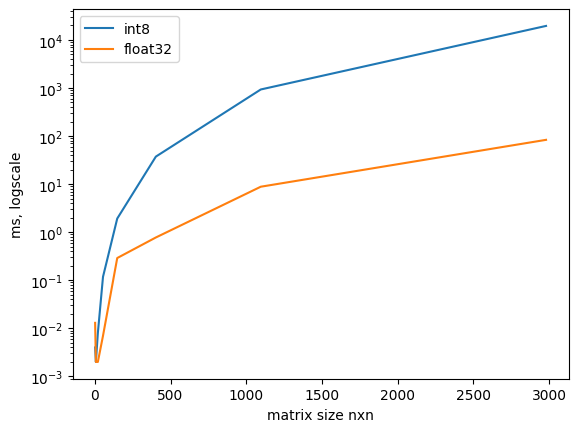

In [22]:

plt.plot(res["n"], res["int mean_ms"], label="int8")
plt.plot(res["n"], res["float32 mean_ms"], label="float32")
plt.yscale("log")
plt.ylabel("ms, logscale")
plt.xlabel("matrix size nxn")
plt.legend()

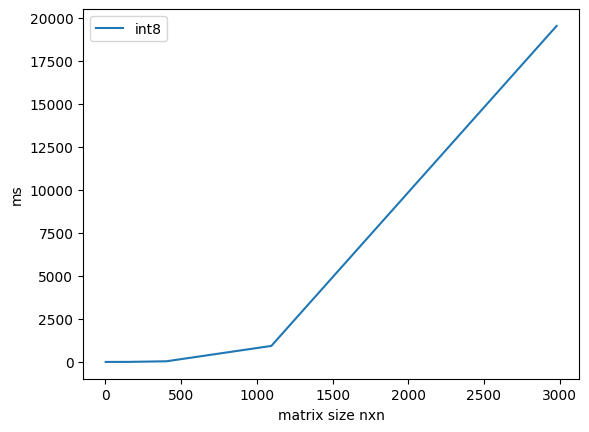

In [25]:
plt.plot(res["n"], res["int mean_ms"], label="int8")
plt.ylabel("ms")
plt.xlabel("matrix size nxn")
plt.legend()

* https://stackoverflow.com/questions/79806482/why-is-eigen-c-int-matrix-multiplication-10x-slower-than-float-multiplication
* Умножение матриц: эффективная реализация шаг за шагом https://habr.com/ru/articles/359272/
* https://arxiv.org/pdf/1609.00076 BLISlab: A Sandbox for Optimizing GEMM
* 

In [3]:
from torch.utils.cpp_extension import load_inline
import torch 
source = """ 
#include <torch/extension.h>

at::Tensor gemm_v0(const at::Tensor& A, const at::Tensor& B)
{
    TORCH_CHECK(A.dtype() == torch::kInt32, "A must be int32");
    TORCH_CHECK(B.dtype() == torch::kInt32, "B must be int32");
    TORCH_CHECK(A.dim() == 2, "A must be 2D");
    TORCH_CHECK(B.dim() == 2, "B must be 2D");
    TORCH_CHECK(A.device().is_cpu(), "A must be on CPU");
    TORCH_CHECK(B.device().is_cpu(), "B must be on CPU");

    auto A_contig = A.contiguous();
    auto B_contig = B.contiguous();

    const int64_t M  = A_contig.size(0);
    const int64_t K1 = A_contig.size(1);
    const int64_t K2 = B_contig.size(0);
    const int64_t N  = B_contig.size(1);

    TORCH_CHECK(K1 == K2, "Inner dims must match: A[M,K], B[K,N]");
    const int64_t K  = K1;

    const int32_t* A_ptr = A_contig.data_ptr<int32_t>();
    const int32_t* B_ptr = B_contig.data_ptr<int32_t>();

    auto C = torch::zeros({M, N}, A_contig.options());
    int32_t* C_ptr = C.data_ptr<int32_t>();

    for (int64_t i = 0; i < M; ++i)
    {
        for (int64_t j = 0; j < N; ++j)
        {
            for (int64_t k = 0; k < K; ++k)
                C_ptr[i * N + j] += A_ptr[i * K + k] * B_ptr[k * N + j];
        }
    }

    return C;
}

at::Tensor gemm_v1(const at::Tensor& A, const at::Tensor& B)
{
    TORCH_CHECK(A.dtype() == torch::kInt32, "A must be int32");
    TORCH_CHECK(B.dtype() == torch::kInt32, "B must be int32");
    TORCH_CHECK(A.dim() == 2, "A must be 2D");
    TORCH_CHECK(B.dim() == 2, "B must be 2D");
    TORCH_CHECK(A.device().is_cpu(), "A must be on CPU");
    TORCH_CHECK(B.device().is_cpu(), "B must be on CPU");

    auto A_contig = A.contiguous();
    auto B_contig = B.contiguous();

    const int64_t M = A_contig.size(0);
    const int64_t K1 = A_contig.size(1);
    const int64_t K2 = B_contig.size(0);
    const int64_t N = B_contig.size(1);

    TORCH_CHECK(K1 == K2, "Inner dims must match: A[M,K], B[K,N]");
    const int64_t K  = K1;

    const int32_t* A_ptr = A_contig.data_ptr<int32_t>();
    const int32_t* B_ptr = B_contig.data_ptr<int32_t>();

    auto C = torch::zeros({M, N}, A_contig.options());
    int32_t* C_ptr = C.data_ptr<int32_t>();

    for (int64_t i = 0; i < M; ++i)
    {
        const int64_t rowA = i * K;
        const int64_t rowC = i * N;

        for (int64_t k = 0; k < K; ++k)
        {
            const int32_t a_ik = A_ptr[rowA + k];
            const int64_t rowB = k * N;

            for (int64_t j = 0; j < N; ++j)
            {
                C_ptr[rowC + j] += a_ik * B_ptr[rowB + j];
            }
        }
    }

    return C;
}

at::Tensor gemm_v2(const at::Tensor& A, const at::Tensor& B)
{
    TORCH_CHECK(A.dtype() == torch::kInt32, "A must be int32");
    TORCH_CHECK(B.dtype() == torch::kInt32, "B must be int32");
    TORCH_CHECK(A.dim() == 2, "A must be 2D");
    TORCH_CHECK(B.dim() == 2, "B must be 2D");
    TORCH_CHECK(A.device().is_cpu(), "A must be on CPU");
    TORCH_CHECK(B.device().is_cpu(), "B must be on CPU");

    auto A_contig = A.contiguous();
    auto B_contig = B.contiguous();

    const int64_t M = A_contig.size(0);
    const int64_t K1 = A_contig.size(1);
    const int64_t K2 = B_contig.size(0);
    const int64_t N = B_contig.size(1);

    TORCH_CHECK(K1 == K2, "Inner dims must match: A[M,K], B[K,N]");
    const int64_t K  = K1;

    const int32_t* A_ptr = A_contig.data_ptr<int32_t>();
    const int32_t* B_ptr = B_contig.data_ptr<int32_t>();

    auto C = torch::zeros({M, N}, A_contig.options());
    int32_t* C_ptr = C.data_ptr<int32_t>();

    for (int64_t i = 0; i < M; ++i)
    {
        const int32_t* rowA_ptr = A_ptr + i * K;
        int32_t* rowC_ptr = C_ptr + i * N;

        for (int64_t k = 0; k < K; ++k)
        {
            const int32_t a_ik = rowA_ptr[k];
            const int32_t* rowB_ptr = B_ptr + k * N;

            for (int64_t j = 0; j < N; ++j)
            {
                rowC_ptr[j] += a_ik * rowB_ptr[j];
            }
        }
    }

    return C;
}

TORCH_LIBRARY(my_op, m)
{
    m.def("gemm_v0", &gemm_v0);
    m.def("gemm_v1", &gemm_v1);
    m.def("gemm_v2", &gemm_v2);
}
"""

module = load_inline(name="my_op",
                    cpp_sources=[source],
                    is_python_module=False,
                    verbose=True,
                    extra_cflags=["-O3", "-std=c++20", "-march=native"],
                    with_cuda=False)
gemm_v0 = torch.ops.my_op.gemm_v0
gemm_v1 = torch.ops.my_op.gemm_v1
gemm_v2 = torch.ops.my_op.gemm_v2

Using C:\Users\user\AppData\Local\torch_extensions\torch_extensions\Cache\py313_cu126 as PyTorch extensions root...
Emitting ninja build file C:\Users\user\AppData\Local\torch_extensions\torch_extensions\Cache\py313_cu126\my_op\build.ninja...
Building extension module my_op...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module my_op...


In [4]:
A = torch.randint(0, 2, (10, 10), dtype=torch.int32)
B = torch.randint(0, 2, (10, 10), dtype=torch.int32)

print((torch.matmul(A, B) != gemm_v0(A, B)).sum())
print((torch.matmul(A, B) != gemm_v1(A, B)).sum())
print((torch.matmul(A, B) != gemm_v2(A, B)).sum())

tensor(0)
tensor(0)
tensor(0)


In [5]:
A = torch.randint(0, 2, (10, 20), dtype=torch.int32)
B = torch.randint(0, 2, (20, 30), dtype=torch.int32)

print((torch.matmul(A, B) != gemm_v0(A, B)).sum())
print((torch.matmul(A, B) != gemm_v1(A, B)).sum())
print((torch.matmul(A, B) != gemm_v2(A, B)).sum())

tensor(0)
tensor(0)
tensor(0)


In [4]:
res = {
    "n": [],
    "torch mean_ms": [],
    "torch std_ms": [],
    "gemm_v0 mean_ms": [],
    "gemm_v0 std_ms": [],
    "gemm_v1 mean_ms": [],
    "gemm_v1 std_ms": [],
    "gemm_v2 mean_ms": [],
    "gemm_v2 std_ms": [],
}

for i in tqdm(range(1, 9)):
    n = int(torch.e ** i)
    res["n"].append(n)

    A = torch.randint(0, 2, (n, n), dtype=torch.int32)
    B = torch.randint(0, 2, (n, n), dtype=torch.int32)

    r_torch = timeit_ms(torch.matmul, A, B, repeat=3, warmup=1)
    res["torch mean_ms"].append(r_torch["mean_ms"])
    res["torch std_ms"].append(r_torch["std_ms"])

    r_g0 = timeit_ms(gemm_v0, A, B, repeat=3, warmup=1)
    res["gemm_v0 mean_ms"].append(r_g0["mean_ms"])
    res["gemm_v0 std_ms"].append(r_g0["std_ms"])

    r_g1 = timeit_ms(gemm_v1, A, B, repeat=3, warmup=1)
    res["gemm_v1 mean_ms"].append(r_g1["mean_ms"])
    res["gemm_v1 std_ms"].append(r_g1["std_ms"])

    r_g2 = timeit_ms(gemm_v2, A, B, repeat=3, warmup=1)
    res["gemm_v2 mean_ms"].append(r_g2["mean_ms"])
    res["gemm_v2 std_ms"].append(r_g2["std_ms"])

100%|██████████| 8/8 [14:05<00:00, 105.72s/it]


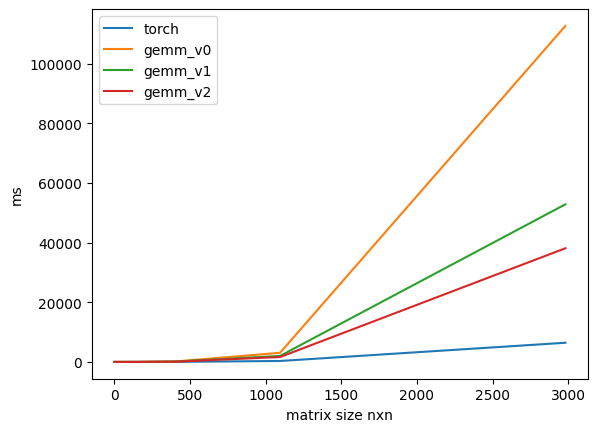

In [5]:
plt.plot(res["n"], res["torch mean_ms"], label="torch")
plt.plot(res["n"], res["gemm_v0 mean_ms"], label="gemm_v0")
plt.plot(res["n"], res["gemm_v1 mean_ms"], label="gemm_v1")
plt.plot(res["n"], res["gemm_v2 mean_ms"], label="gemm_v2")
plt.ylabel("ms")
plt.xlabel("matrix size nxn")
plt.legend()

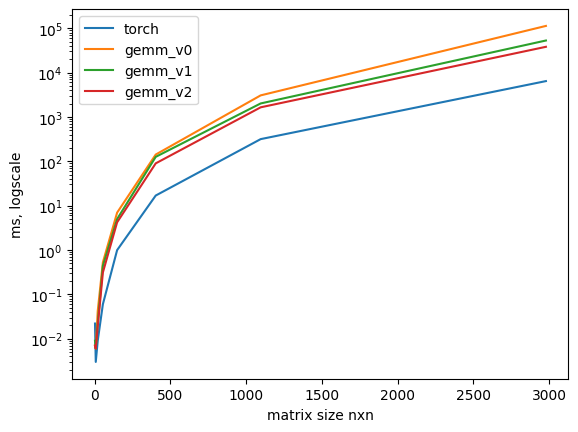

In [7]:
plt.plot(res["n"], res["torch mean_ms"], label="torch")
plt.plot(res["n"], res["gemm_v0 mean_ms"], label="gemm_v0")
plt.plot(res["n"], res["gemm_v1 mean_ms"], label="gemm_v1")
plt.plot(res["n"], res["gemm_v2 mean_ms"], label="gemm_v2")
plt.yscale("log")
plt.ylabel("ms, logscale")
plt.xlabel("matrix size nxn")
plt.legend()

In [1]:
from torch.utils.cpp_extension import load_inline
import torch 
source = """ 
#include <torch/extension.h>

at::Tensor gemm_v3(const at::Tensor& A, const at::Tensor& B)
{
    TORCH_CHECK(A.dtype() == torch::kInt32, "A must be int32");
    TORCH_CHECK(B.dtype() == torch::kInt32, "B must be int32");
    TORCH_CHECK(A.dim() == 2, "A must be 2D");
    TORCH_CHECK(B.dim() == 2, "B must be 2D");
    TORCH_CHECK(A.device().is_cpu(), "A must be on CPU");
    TORCH_CHECK(B.device().is_cpu(), "B must be on CPU");

    auto A_contig = A.contiguous();
    auto B_contig = B.contiguous();

    const int64_t M = A_contig.size(0);
    const int64_t K = A_contig.size(1);
    TORCH_CHECK(K == B_contig.size(0), "Inner dims must match: A[M,K], B[K,N]");
    const int64_t N = B_contig.size(1);

    const int32_t* A_ptr = A_contig.data_ptr<int32_t>();
    const int32_t* B_ptr = B_contig.data_ptr<int32_t>();

    auto C = torch::zeros({M, N}, A_contig.options());
    int32_t* C_ptr = C.data_ptr<int32_t>();

    constexpr int64_t BK = 64;
    constexpr int64_t BJ = 64;

    for (int64_t i = 0; i < M; ++i)
    {
        const int32_t* rowA_ptr = A_ptr + i * K;
        int32_t* rowC_ptr = C_ptr + i * N;

        for (int64_t jb = 0; jb < N; jb += BJ)
        {
            const int64_t jmax = std::min(jb + BJ, N);

            for (int64_t kb = 0; kb < K; kb += BK)
            {
                const int64_t kmax = std::min(kb + BK, K);

                for (int64_t k = kb; k < kmax; ++k)
                {
                    const int32_t a_ik = rowA_ptr[k];
                    const int32_t* rowB_ptr = B_ptr + k * N;

                    for (int64_t j = jb; j < jmax; ++j)
                    {
                        rowC_ptr[j] += a_ik * rowB_ptr[j];
                    }
                }
            }
        }
    }

    return C;
}

TORCH_LIBRARY(my_op2, m)
{
    m.def("gemm_v3", &gemm_v3);
}
"""

module = load_inline(name="my_op2",
                    cpp_sources=[source],
                    is_python_module=False,
                    verbose=True,
                    extra_cflags=["-O3", "-std=c++20", "-march=native"],
                    with_cuda=False)
gemm_v3 = torch.ops.my_op2.gemm_v3

Using C:\Users\user\AppData\Local\torch_extensions\torch_extensions\Cache\py313_cu126 as PyTorch extensions root...
Emitting ninja build file C:\Users\user\AppData\Local\torch_extensions\torch_extensions\Cache\py313_cu126\my_op2\build.ninja...
Building extension module my_op2...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module my_op2...


In [6]:
A = torch.randint(0, 2, (10, 20), dtype=torch.int32)
B = torch.randint(0, 2, (20, 30), dtype=torch.int32)
print((torch.matmul(A, B) != gemm_v3(A, B)).sum())

A = torch.randint(0, 2, (10, 10), dtype=torch.int32)
B = torch.randint(0, 2, (10, 10), dtype=torch.int32)
print((torch.matmul(A, B) != gemm_v3(A, B)).sum())

tensor(0)
tensor(0)


In [7]:
res = {
    "n": [],
    "torch mean_ms": [],
    "torch std_ms": [],
    "gemm_v2 mean_ms": [],
    "gemm_v2 std_ms": [],
    "gemm_v3 mean_ms": [],
    "gemm_v3 std_ms": [],
}

for i in tqdm(range(1, 9)):
    n = int(torch.e ** i)
    res["n"].append(n)

    A = torch.randint(0, 2, (n, n), dtype=torch.int32)
    B = torch.randint(0, 2, (n, n), dtype=torch.int32)

    r_torch = timeit_ms(torch.matmul, A, B, repeat=3, warmup=1)
    res["torch mean_ms"].append(r_torch["mean_ms"])
    res["torch std_ms"].append(r_torch["std_ms"])

    r_g2 = timeit_ms(gemm_v2, A, B, repeat=3, warmup=1)
    res["gemm_v2 mean_ms"].append(r_g2["mean_ms"])
    res["gemm_v2 std_ms"].append(r_g2["std_ms"])

    r_g3 = timeit_ms(gemm_v3, A, B, repeat=3, warmup=1)
    res["gemm_v3 mean_ms"].append(r_g3["mean_ms"])
    res["gemm_v3 std_ms"].append(r_g3["std_ms"])

100%|██████████| 8/8 [05:26<00:00, 40.81s/it]


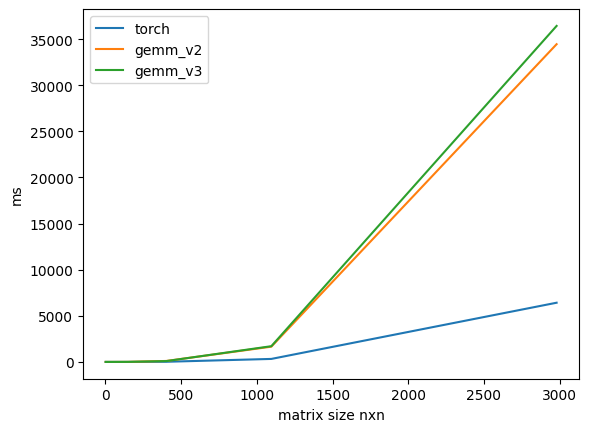

In [8]:
plt.plot(res["n"], res["torch mean_ms"], label="torch")
plt.plot(res["n"], res["gemm_v2 mean_ms"], label="gemm_v2")
plt.plot(res["n"], res["gemm_v3 mean_ms"], label="gemm_v3")
plt.ylabel("ms")
plt.xlabel("matrix size nxn")
plt.legend()

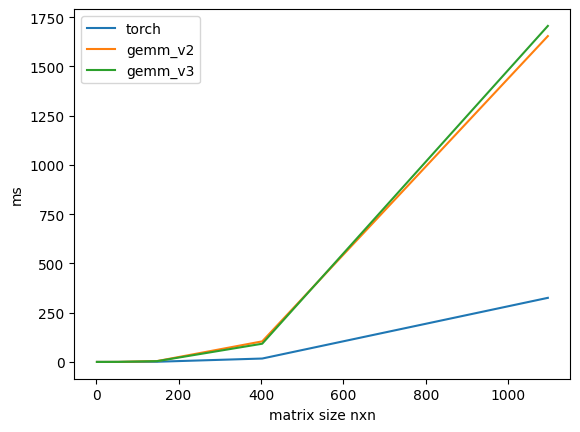

In [10]:
plt.plot(res["n"][:-1], res["torch mean_ms"][:-1], label="torch")
plt.plot(res["n"][:-1], res["gemm_v2 mean_ms"][:-1], label="gemm_v2")
plt.plot(res["n"][:-1], res["gemm_v3 mean_ms"][:-1], label="gemm_v3")
plt.ylabel("ms")
plt.xlabel("matrix size nxn")
plt.legend()

In [11]:
res = {
    "n": [],
    "torch mean_ms": [],
    "torch std_ms": [],
    "gemm_v2 mean_ms": [],
    "gemm_v2 std_ms": [],
    "gemm_v3 mean_ms": [],
    "gemm_v3 std_ms": [],
}

for i in tqdm(range(1, 12)):
    n = int(2 ** i)
    res["n"].append(n)

    A = torch.randint(0, 2, (n, n), dtype=torch.int32)
    B = torch.randint(0, 2, (n, n), dtype=torch.int32)

    r_torch = timeit_ms(torch.matmul, A, B, repeat=3, warmup=1)
    res["torch mean_ms"].append(r_torch["mean_ms"])
    res["torch std_ms"].append(r_torch["std_ms"])

    r_g2 = timeit_ms(gemm_v2, A, B, repeat=3, warmup=1)
    res["gemm_v2 mean_ms"].append(r_g2["mean_ms"])
    res["gemm_v2 std_ms"].append(r_g2["std_ms"])

    r_g3 = timeit_ms(gemm_v3, A, B, repeat=3, warmup=1)
    res["gemm_v3 mean_ms"].append(r_g3["mean_ms"])
    res["gemm_v3 std_ms"].append(r_g3["std_ms"])

100%|██████████| 11/11 [02:15<00:00, 12.35s/it]


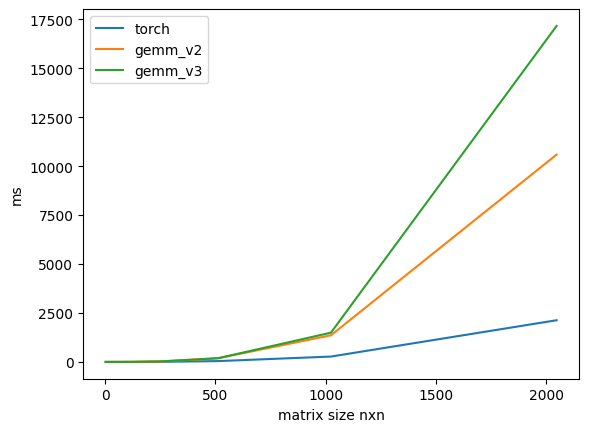

In [12]:
plt.plot(res["n"], res["torch mean_ms"], label="torch")
plt.plot(res["n"], res["gemm_v2 mean_ms"], label="gemm_v2")
plt.plot(res["n"], res["gemm_v3 mean_ms"], label="gemm_v3")
plt.ylabel("ms")
plt.xlabel("matrix size nxn")
plt.legend()

In [2]:
from torch.utils.cpp_extension import load_inline
import torch 
source = """ 
#include <torch/extension.h>
#include <ATen/Parallel.h>

at::Tensor gemm_v2_parallel(const at::Tensor& A, const at::Tensor& B)
{
    TORCH_CHECK(A.dtype() == torch::kInt32, "A must be int32");
    TORCH_CHECK(B.dtype() == torch::kInt32, "B must be int32");
    TORCH_CHECK(A.dim() == 2, "A must be 2D");
    TORCH_CHECK(B.dim() == 2, "B must be 2D");
    TORCH_CHECK(A.device().is_cpu(), "A must be on CPU");
    TORCH_CHECK(B.device().is_cpu(), "B must be on CPU");

    auto A_contig = A.contiguous();
    auto B_contig = B.contiguous();

    const int64_t M = A_contig.size(0);
    const int64_t K1 = A_contig.size(1);
    const int64_t K2 = B_contig.size(0);
    const int64_t N = B_contig.size(1);

    TORCH_CHECK(K1 == K2, "Inner dims must match: A[M,K], B[K,N]");
    const int64_t K  = K1;

    const int32_t* A_ptr = A_contig.data_ptr<int32_t>();
    const int32_t* B_ptr = B_contig.data_ptr<int32_t>();

    auto C = torch::zeros({M, N}, A_contig.options());
    int32_t* C_ptr = C.data_ptr<int32_t>();

    at::parallel_for(0, M, 16, [&](int64_t begin, int64_t end)
    {
        for (int64_t i = begin; i < end; ++i)
        {
            const int32_t* rowA_ptr = A_ptr + i * K;
            int32_t* rowC_ptr = C_ptr + i * N;

            for (int64_t k = 0; k < K; ++k)
            {
                const int32_t a_ik = rowA_ptr[k];
                const int32_t* rowB_ptr = B_ptr + k * N;

                for (int64_t j = 0; j < N; ++j)
                {
                    rowC_ptr[j] += a_ik * rowB_ptr[j];
                }
            }
        }
    });

    return C;
}

at::Tensor gemm_v3_parallel(const at::Tensor& A, const at::Tensor& B)
{
    TORCH_CHECK(A.dtype() == torch::kInt32, "A must be int32");
    TORCH_CHECK(B.dtype() == torch::kInt32, "B must be int32");
    TORCH_CHECK(A.dim() == 2, "A must be 2D");
    TORCH_CHECK(B.dim() == 2, "B must be 2D");
    TORCH_CHECK(A.device().is_cpu(), "A must be on CPU");
    TORCH_CHECK(B.device().is_cpu(), "B must be on CPU");

    auto A_contig = A.contiguous();
    auto B_contig = B.contiguous();

    const int64_t M = A_contig.size(0);
    const int64_t K = A_contig.size(1);
    TORCH_CHECK(K == B_contig.size(0), "Inner dims must match: A[M,K], B[K,N]");
    const int64_t N = B_contig.size(1);

    const int32_t* A_ptr = A_contig.data_ptr<int32_t>();
    const int32_t* B_ptr = B_contig.data_ptr<int32_t>();

    auto C = torch::zeros({M, N}, A_contig.options());
    int32_t* C_ptr = C.data_ptr<int32_t>();

    constexpr int64_t BK = 128;
    constexpr int64_t BJ = 128;

    at::parallel_for(0, M, 16, [&](int64_t begin, int64_t end)
    {
        for (int64_t i = begin; i < end; ++i)
        {
            const int32_t* rowA_ptr = A_ptr + i * K;
            int32_t* rowC_ptr = C_ptr + i * N;

            for (int64_t jb = 0; jb < N; jb += BJ)
            {
                const int64_t jmax = std::min(jb + BJ, N);

                for (int64_t kb = 0; kb < K; kb += BK)
                {
                    const int64_t kmax = std::min(kb + BK, K);

                    for (int64_t k = kb; k < kmax; ++k)
                    {
                        const int32_t a_ik = rowA_ptr[k];
                        const int32_t* rowB_ptr = B_ptr + k * N;

                        for (int64_t j = jb; j < jmax; ++j)
                        {
                            rowC_ptr[j] += a_ik * rowB_ptr[j];
                        }
                    }
                }
            }
        }
    });

    return C;
}


TORCH_LIBRARY(my_op_parallel, m)
{
    m.def("gemm_v2_parallel", &gemm_v2_parallel);
    m.def("gemm_v3_parallel", &gemm_v3_parallel);
}
"""

module = load_inline(name="my_op_parallel",
                    cpp_sources=[source],
                    is_python_module=False,
                    verbose=True,
                    extra_cflags=["-O3", "-std=c++20", "-march=native"],
                    with_cuda=False)
gemm_v2_parallel = torch.ops.my_op_parallel.gemm_v2_parallel
gemm_v3_parallel = torch.ops.my_op_parallel.gemm_v3_parallel

Using C:\Users\user\AppData\Local\torch_extensions\torch_extensions\Cache\py313_cu126 as PyTorch extensions root...
Emitting ninja build file C:\Users\user\AppData\Local\torch_extensions\torch_extensions\Cache\py313_cu126\my_op_parallel\build.ninja...
Building extension module my_op_parallel...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module my_op_parallel...


In [3]:
A = torch.randint(0, 2, (10, 20), dtype=torch.int32)
B = torch.randint(0, 2, (20, 30), dtype=torch.int32)
print((torch.matmul(A, B) != gemm_v2_parallel(A, B)).sum())
print((torch.matmul(A, B) != gemm_v3_parallel(A, B)).sum())

A = torch.randint(0, 2, (10, 10), dtype=torch.int32)
B = torch.randint(0, 2, (10, 10), dtype=torch.int32)
print((torch.matmul(A, B) != gemm_v2_parallel(A, B)).sum())
print((torch.matmul(A, B) != gemm_v3_parallel(A, B)).sum())

tensor(0)
tensor(0)
tensor(0)
tensor(0)


In [4]:
res = {
    "n": [],
    "torch mean_ms": [],
    "torch std_ms": [],
    "gemm_v2_parallel mean_ms": [],
    "gemm_v2_parallel std_ms": [],
    "gemm_v3_parallel mean_ms": [],
    "gemm_v3_parallel std_ms": [],
}

for i in tqdm(range(1, 9)):
    n = int(torch.e ** i)
    res["n"].append(n)

    A = torch.randint(0, 2, (n, n), dtype=torch.int32)
    B = torch.randint(0, 2, (n, n), dtype=torch.int32)

    r_torch = timeit_ms(torch.matmul, A, B, repeat=3, warmup=1)
    res["torch mean_ms"].append(r_torch["mean_ms"])
    res["torch std_ms"].append(r_torch["std_ms"])

    r_g2 = timeit_ms(gemm_v2_parallel, A, B, repeat=3, warmup=1)
    res["gemm_v2_parallel mean_ms"].append(r_g2["mean_ms"])
    res["gemm_v2_parallel std_ms"].append(r_g2["std_ms"])

    r_g3 = timeit_ms(gemm_v3_parallel, A, B, repeat=3, warmup=1)
    res["gemm_v3_parallel mean_ms"].append(r_g3["mean_ms"])
    res["gemm_v3_parallel std_ms"].append(r_g3["std_ms"])

100%|██████████| 8/8 [07:44<00:00, 58.07s/it]


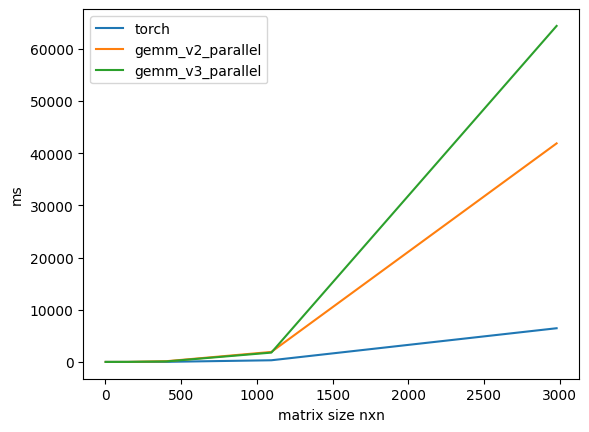

In [5]:
plt.plot(res["n"], res["torch mean_ms"], label="torch")
plt.plot(res["n"], res["gemm_v2_parallel mean_ms"], label="gemm_v2_parallel")
plt.plot(res["n"], res["gemm_v3_parallel mean_ms"], label="gemm_v3_parallel")
plt.ylabel("ms")
plt.xlabel("matrix size nxn")
plt.legend()